# Prior and posterior predictive distributions

In [3]:
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
import scipy.stats as stats

## Prior distribution selection

In [4]:
# since there are 20% reactions on average, we're looking at a distribution with mean=0.2
# the beta distribution has an average equal to a/(a+b), so we can easily find a suitable pair of parameters
# for example:
mean, *_ = stats.beta.stats(a=4, b=16)
mean
# let's use this pair of params

0.2

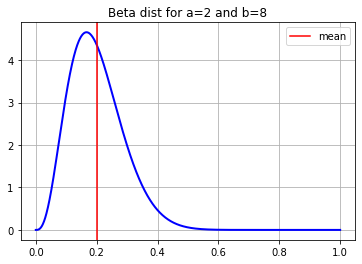

In [5]:
x = np.linspace(0, 1, 1000)
rv = stats.beta(a=4, b=16)
plt.plot(x, rv.pdf(x), 'b', lw=2)
plt.axvline(x=mean, color='r', label='mean')
plt.title('Beta dist for a=2 and b=8')
plt.grid()
plt.legend()
plt.show()

## Modelling prior distribution

In [23]:
%%writefile model_1.stan

generated quantities {
  int<lower=0> N = 50; 
  real<lower=0, upper=1> p = beta_rng(4, 16); 
  int<lower=0, upper=N> y = binomial_rng(N, p);
}


Overwriting model_1.stan


In [24]:
gen_quant = CmdStanModel(stan_file='model_1.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab3/model_1.stan to exe file /home/labs/DataAnalytics2023/Lab3/model_1


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab3/model_1


In [28]:
samples = gen_quant.sample(iter_sampling=1000, chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [29]:
df = samples.draws_pd()
df.head()

,lp__,accept_stat__,N,p,y
0,0.0,0.0,50.0,0.168899,6.0
1,0.0,0.0,50.0,0.180324,10.0
2,0.0,0.0,50.0,0.074477,2.0
3,0.0,0.0,50.0,0.288559,11.0
4,0.0,0.0,50.0,0.127593,6.0


In [30]:
df.describe()

,lp__,accept_stat__,N,p,y
count,1000.0,1000.0,1000.0,1000.000000,1000.000000
mean,0.0,0.0,50.0,0.204386,10.227000
std,0.0,0.0,0.0,0.089120,5.249288
min,0.0,0.0,50.0,0.018904,0.000000
25%,0.0,0.0,50.0,0.140095,6.000000
50%,0.0,0.0,50.0,0.191485,10.000000
75%,0.0,0.0,50.0,0.258310,13.000000
max,0.0,0.0,50.0,0.596084,35.000000


In [31]:
df['ratio'] = df.y / 50
mean = df['ratio'].mean()
print(f"mean from generated samples: [{mean}]")
print(f"difference to the exact value of 0.2: [{abs(mean - 0.2)}]")
print(f"expressed as percentage of 0.2: [{abs(mean - 0.2)/0.2 * 100.0}]")
# as we can see the percentage error quite small

mean from generated samples: [0.20454000000000003]
difference to the exact value of 0.2: [0.004540000000000016]
expressed as percentage of 0.2: [2.270000000000008]


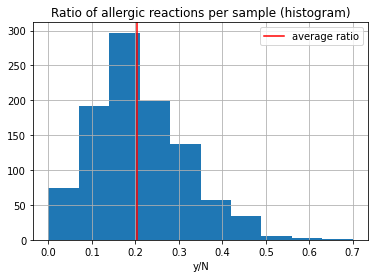

In [32]:
df['ratio'].hist(bins=10)
plt.axvline(x=mean, color ='r', label='average ratio')
plt.xlabel("y/N")
plt.title('Ratio of allergic reactions per sample (histogram)')
plt.legend()
plt.show()
# the average (as well as the general shape of the histogram) seems to be aligned with the prior beta distribution

## Modeling posterior and posterior predictive distribution

In [33]:
%%writefile model_2.stan

data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
}

parameters {
  real<lower=0, upper=1> p;
}

model {
  p ~ beta(4, 12); // prior
  y ~ binomial(N, p);
}

generated quantities {
  int<lower=0, upper=N> y_pred = binomial_rng(N, p);
}

Overwriting model_2.stan


In [34]:
gen_quant = CmdStanModel(stan_file='model_2.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab3/model_2.stan to exe file /home/labs/DataAnalytics2023/Lab3/model_2
INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab3/model_2


In [35]:
samples = gen_quant.sample(data={'N': 50, 'y': 7})

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [36]:
df = samples.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-30.4811,0.934482,0.85881,2.0,3.0,0.0,30.8167,0.115882,5.0
1,-29.7469,0.981294,0.85881,1.0,3.0,0.0,30.6256,0.160304,7.0
2,-29.7632,0.991710,0.85881,1.0,3.0,0.0,29.8092,0.177343,13.0
3,-29.7483,0.995097,0.85881,1.0,3.0,0.0,29.8103,0.159867,10.0
4,-31.3722,0.809416,0.85881,2.0,3.0,0.0,31.4184,0.095192,5.0


In [37]:
df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000
mean,-30.231181,0.918709,0.982282,1.378250,2.497000,0.0,30.728832,0.166666,8.338500
std,0.712796,0.122773,0.079361,0.485011,1.158156,0.0,0.995576,0.044874,3.364112
min,-35.747200,0.022824,0.858810,1.000000,1.000000,0.0,29.737200,0.050167,0.000000
25%,-30.385675,0.889825,0.940723,1.000000,1.000000,0.0,30.019575,0.135579,6.000000
50%,-29.952550,0.969527,1.003953,1.000000,3.000000,0.0,30.421350,0.162663,8.000000
75%,-29.784000,1.000000,1.045513,2.000000,3.000000,0.0,31.113325,0.195735,10.000000
max,-29.737000,1.000000,1.062410,2.000000,7.000000,0.0,36.527100,0.355247,24.000000


In [38]:
ratios = df['y_pred'] / 50
ratios = ratios.to_numpy()

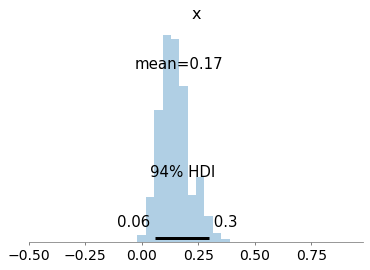

In [39]:
az.plot_posterior(ratios, kind='hist', hdi_prob=0.94, point_estimate='mean')
plt.show()

In [40]:
p = df['p'].to_numpy()

ratio_mean = np.mean(ratios)
ratio_hdi = az.hdi(ratios, hdi_prob=0.94)

p_mean = np.mean(p)
p_hdi = az.hdi(p, hdi_prob=0.94)

print(f"Predicted ratio: [mean:[{ratio_mean}], 94_HDI:{ratio_hdi}]")
print(f"Parameter p: [mean:[{p_mean}], 94_HDI:{p_hdi}]")

p_avg = 0.2
ratio_prob = np.mean(ratios < p_avg)

print(f"Probability that ratio is lower than average: [{ratio_prob}]")

Predicted ratio: [mean:[0.16677], 94_HDI:[0.06 0.3 ]]
Parameter p: [mean:[0.16666592065], 94_HDI:[0.082883 0.248006]]
Probability that ratio is lower than average: [0.658]
